First we import all the required modules

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First we choose the dataset blood-fat.csv and import the data:

In [15]:
bloodfatdata = pd.read_csv("./datasets/blood-fat.csv")

bloodfatdata

,Weight,Age,Blood fat
0,84,46,354
1,73,20,190
2,65,52,405
3,70,30,263
4,76,57,451
5,69,25,302
6,63,28,288
7,72,36,385
8,79,57,402
9,75,44,365


Now we can summarize the data by evaluating the statistics

In [16]:
bloodfatdata.describe()

,Weight,Age,Blood fat
count,25.000000,25.000000,25.00000
mean,68.680000,39.120000,310.72000
std,12.727005,12.248537,77.82915
min,27.000000,20.000000,181.00000
25%,63.000000,30.000000,254.00000
50%,69.000000,37.000000,303.00000
75%,76.000000,50.000000,374.00000
max,89.000000,60.000000,451.00000


Now we can visualize the data by creating a pairplot with pairwise feature scatterplots and feature histograms:

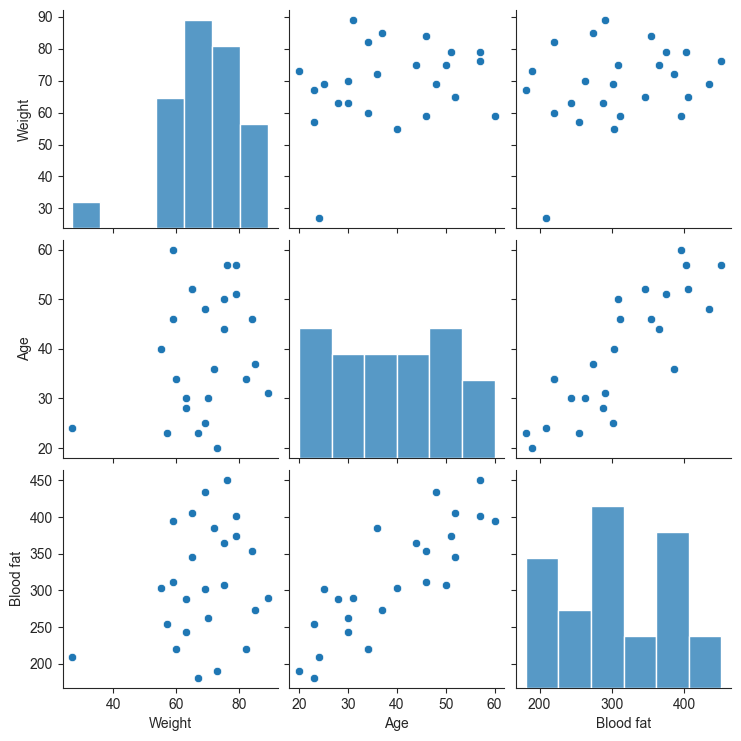

In [20]:
sns.set_style('ticks')
sns.pairplot(data=bloodfatdata)

Now we can also create a heatmap out of the feature correlation matrix

<Axes: >

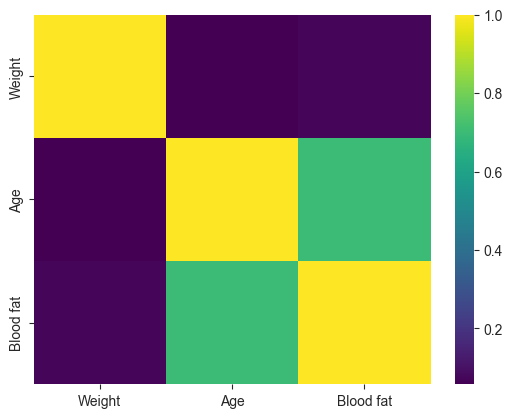

In [23]:
correlation_matrix = bloodfatdata.corr(numeric_only=True)
correlation_matrix
sns.heatmap(correlation_matrix ** 2, cmap='viridis')